In [1]:
from fastai.text import * 
from fastai.callbacks import *
from sklearn.model_selection import train_test_split
from pathlib import Path
import pickle as pkl

In [2]:
PATH = Path('.')
MODELS_PATH = PATH / 'models'
MODELS_PATH.mkdir(exist_ok=True)

In [3]:
import unicodedata
import pandas as pd
import re
import spacy
import json

In [4]:
def normalize_title(title):
    s = re.sub(r'[^a-zA-Z0-9ñç% ]', ' ', unicodedata.normalize('NFKD', title.lower()).encode('ascii', 'ignore').decode("utf-8"))
#    s = re.sub(r'[\d]+', "1", s)
    s = re.sub(r's |s$', ' ', s)
    s = re.sub(r' +', ' ', s)
    s = re.sub(r'(1 )+', '1 ', s)
    return re.sub(r'o |o$', 'a ', s).strip()

In [9]:
with open("main_categories.json", "r") as f:
    cats = json.load(f)

In [6]:
df = pd.read_csv(PATH / 'train.csv', nrows = 50000)
df = df[df.language == 'spanish']
df = df.head(10000)
#df.category = df.category.map(cats)
df.title = df.title.apply(normalize_title)
df = df[~df.title.isna() & (df.title != 'nan') & (df.title != '')]

In [7]:
df.head()

,title,label_quality,language,category
0,hidrolavadora lavor one 120 bar 1700w bomba al...,unreliable,spanish,ELECTRIC_PRESSURE_WASHERS
1,placa de sonida behringer umc22,unreliable,spanish,SOUND_CARDS
4,flashe led pestana luminosa falsa pestana para...,unreliable,spanish,FALSE_EYELASHES
9,gatita lunchera neoprene,unreliable,spanish,LUNCHBOXES
11,rosaria contador de billete uv mg detecta fals...,unreliable,spanish,BILL_COUNTERS


In [8]:
df.title.apply(lambda x: len(x.split(" "))).sum(axis = 0)

75055647

In [7]:
data_lm = (TextList.from_df(df, cols=['title'])
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()
    .databunch(bs=96, num_workers=1))

In [8]:
data_lm.save('data_lm_v3_export.pkl')

In [7]:
data_lm = load_data('', 'data_lm_v3_export.pkl', bs=64)

In [7]:
len(data_lm.vocab.itos),len(data_lm.train_ds), len(data_lm.vocab.stoi)

(60000, 8999972, 60000)

In [10]:
data_lm.show_batch(rows=10)

idx,text
0,mm xxbos maquina para sublimar estampar goldex 60x40 xxbos notebook hp pavilion xxunk special edition xxbos maquina de coser brother industrial xxbos fernet branca menta 450 cc 100 x caja xxbos oportunidad notebook dell i3 4 gb ddr4 hd 1 tb win 10 xxbos schwarzkopf fibre force mascarilla fortificante xxbos atornillador taladra inalambrica amoladora philca xxunk xxbos hermosa arbol de navidad en madera de pina xxbos bateria honda transalp 600
1,artec pedal xxunk distorsion fuzz town xxbos xxunk anilla disena gata gatita dormilon regala bijou animal xxbos bomba de frena doble circuita chevrolet a20 89 93 xxbos casia calculadora cientifica fx 991la x xxbos titere deda animale gata gatita 75 cada una na peluche xxbos paleta padel royalpadel fuel advanced eva xxbos mila colombiana 500 gr xxbos microonda bgh b228d plata aloise virtual xxbos raton portatil xxunk de marca estrecha
2,fox 3 pta xxbos cadena ek threed 520sm 120l kawasaki klx c 650 1993 1996 c xxbos campana pesca campanita metal alarma pique pack 2 unidade xxbos corsair xxunk rgb 120 mm x3 xxbos radiador vw xxunk xxunk xxbos bralette print xxbos insignia baul peugeot 306 95 97 numera cromada xxbos autoesterea xxunk noblex con puerta usb xxbos almohadon 40x40 honda 023 jdm vtec vti si doma eg xxbos diafragma
3,percutor gamma 10 mm 650 watt reversa c accesoria xxbos comba pisa flotante kronoswis manta zocala 8 mm ac4 xxbos mecedora infanti hamaca bebe infanti bebesit xxbos paragua avenger vengadore original linea premium marvel xxbos pila sony 377 sr626sw blister caja x 100 oxida de plata xxbos clora inst multiaccion nataclor x 1 kg ferreteria expres xxbos arbol de navidad artificial grande resistente bolsa limpiar xxbos semieje toyota tacoma 95
4,50 kg pesa removible xxbos licuadora de mana yelma xxunk kit batidor bol picador xxbos aprieta papel binder mit negra 51 mm x 12 unidade xxbos guia xxunk rouser 180 original bajaj rvm xxbos rueda deore xt m8000 r29 xxbos tricicla plastica vegui qria xxbos asienta conductor custom 200 motomel choppera outlet xxbos destornillador bahca caba verde plana 5x100 mm 3150 100 xxbos cacha de espeja peugeot 308 408 original
5,xxbos time chamber coloring book xxbos vincha forrada artesanale lote x 10 xxbos kit 4 bujia ferrazzi iridium ford galaxy 2 0 inyeccion xxbos calca tm mx 85 xxbos parte de carroceria p up chev luv 92 96 capot xxbos 20 bolsita 20 pochoclera personalizada xxbos apple ipod shuffle 2 gb 5ta generacion oportunidad xxbos micrometra tubular interior extensible 50 250 mm thebmya xxbos arbol de leva ford escort 1
6,honda xxbos xxunk de baja laney xxunk xxunk xxbos taladra inalambrica black decker cd121k100 12v ahora 18 xxbos bolsa arranque 30x40 1 5 kg xxbos pestana postiza artistica disfrace xxbos afeitadora electrica cara cortadora barba multifuncion gama afeita en seca a humeda crema a gel de afeitar garantia xxbos azul camuflaje pildora carbona rocker gotea rueda de tambor xxbos cuna practicuna bebe plegable moon facil guardada infanti xxbos ukelele de
7,lycra sport bicolor lf only xxbos disfraz marinera talle unica na incluye media xxbos esponja de maquillaje simil beauty blender xxbos jm casca mota mujer mac street amy blanca rosa envia grati xxbos maza carta tarot xxunk della corte di merlina xxbos tetera pava hierra fundida infusor acera inox hebra 500ml xxbos selladora bolsa 20 cm nylon friselina xxbos antigua figura de caballa en bronce maciza para ornamenta xxbos scanner
8,aceite motor nissan 370z 08 15 3 7 iny 24v vh xxunk xxbos oxida nitrica mervick 150 g palerma xxbos calefactor por conveccion vidria templada 2000wt xxbos filtra alta fluja kyn r 1650 f ya all 1650 xxbos telefona mesa xxunk ml xxunk 12 dig mana libre dual tran xxbos tobera de kawasaki ninja 250 r xxunk fabian part xxbos sensor de temperatura set modula xxunk tipa k modula grada
9,xxunk yamaha fc5 xxbos escaner manual portatil de mana xxunk zoom recargable xxunk xxbos pack x4 luz proton rgb dj iluminacion fiesta eventa dmx 18 xxbos escape

In [14]:
perplexity = Perplexity()
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, pretrained=False, 
                               metrics=[accuracy, perplexity])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


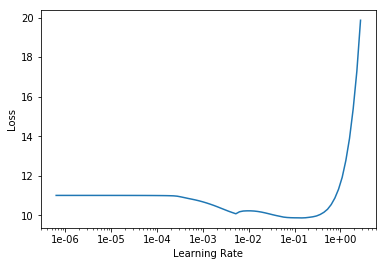

In [13]:
learn.lr_find()
learn.recorder.plot()

In [15]:
lr = 4e-3

In [16]:
learn.fit_one_cycle(10, lr, moms=(0.8,0.7), 
                    callbacks=[SaveModelCallback(learn, monitor='accuracy', name='best_lm_v3')])

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.781138,4.665714,0.269278,106.241440,1:06:45
1,4.615019,4.471512,0.279891,87.489189,1:05:49
2,4.549683,4.415385,0.283175,82.713860,1:07:06
3,4.479922,4.351849,0.288749,77.622124,1:06:40
4,4.409403,4.283460,0.295611,72.490456,1:06:55
5,4.342499,4.210450,0.302636,67.387001,1:06:03
6,4.259175,4.135723,0.310652,62.534969,1:07:07
7,4.188394,4.069490,0.318260,58.527103,1:06:40
8,4.121712,4.025741,0.323744,56.021839,1:06:11
9,4.091391,4.014114,0.325224,55.374233,1:06:51


Better model found at epoch 0 with accuracy value: 0.2692776024341583.
Better model found at epoch 1 with accuracy value: 0.2798914313316345.
Better model found at epoch 2 with accuracy value: 0.2831745743751526.
Better model found at epoch 3 with accuracy value: 0.2887486219406128.
Better model found at epoch 4 with accuracy value: 0.2956114113330841.
Better model found at epoch 5 with accuracy value: 0.30263611674308777.
Better model found at epoch 6 with accuracy value: 0.31065240502357483.
Better model found at epoch 7 with accuracy value: 0.3182602524757385.
Better model found at epoch 8 with accuracy value: 0.3237444758415222.
Better model found at epoch 9 with accuracy value: 0.3252241611480713.


In [20]:
learn.load('best_lm_v3');

In [17]:
learn.unfreeze()
wd = 0.01 
learn.fit_one_cycle(10, lr, wd=wd, moms=(0.8,0.7), 
                    callbacks=[SaveModelCallback(learn.to_fp32(), monitor='accuracy', name='best_lm_v3')])

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,4.325352,4.309789,0.697576,0.302425,74.424973,47:51
1,4.054984,4.056368,0.676989,0.323011,57.764175,47:36
2,3.978574,3.977717,0.671535,0.328465,53.395039,47:43
3,3.871433,3.879084,0.661038,0.338962,48.379906,47:17
4,3.774092,3.793369,0.651632,0.348370,44.405678,47:22
5,3.677126,3.702215,0.640092,0.359908,40.536915,48:07
6,3.563842,3.608304,0.628212,0.371789,36.903263,47:05
7,3.448874,3.522034,0.615705,0.384295,33.853149,46:44
8,3.350172,3.466978,0.606776,0.393224,32.039711,47:42
9,3.278136,3.457582,0.604433,0.395567,31.740067,47:47


Better model found at epoch 0 with accuracy value: 0.3024246394634247.
Better model found at epoch 1 with accuracy value: 0.32301071286201477.
Better model found at epoch 2 with accuracy value: 0.328464537858963.
Better model found at epoch 3 with accuracy value: 0.3389618694782257.
Better model found at epoch 4 with accuracy value: 0.34836965799331665.
Better model found at epoch 5 with accuracy value: 0.3599082827568054.
Better model found at epoch 6 with accuracy value: 0.3717890679836273.
Better model found at epoch 7 with accuracy value: 0.38429465889930725.
Better model found at epoch 8 with accuracy value: 0.39322414994239807.
Better model found at epoch 9 with accuracy value: 0.39556747674942017.


In [27]:
learn.data.vocab.save(('models/v3_vocab' + '.pkl'))

In [26]:
learn.predict('celular moto g', 10, temperature=0.75)

'celular moto g dual sim 4 g lte nueva libre local factura a'

In [23]:
data_lm = load_data('', 'data_lm_v3_export.pkl', bs=64)

In [23]:
learn.save_encoder('best_lm_v3_encoder')

In [10]:
df.category = df.category.map(cats)

In [11]:
df.head()

,title,label_quality,language,category
0,hidrolavadora lavor one 120 bar 1700w bomba al...,unreliable,spanish,Ferramentas e Construcao
1,placa de sonida behringer umc22,unreliable,spanish,Informatica
4,flashe led pestana luminosa falsa pestana para...,unreliable,spanish,Beleza e Cuidado Pessoal
9,gatita lunchera neoprene,unreliable,spanish,"Arte, Papelaria e Armarinho"
11,rosaria contador de billete uv mg detecta fals...,unreliable,spanish,"Agro, Industria e Comercio"


In [12]:
train, valid = train_test_split(df, test_size=0.1, stratify=df.category, random_state = 42)

In [24]:
data_class = TextDataBunch.from_df('', train_df = train, valid_df = valid, vocab = data_lm.vocab, text_cols=['title'], label_cols=['category'], bs=800, num_workers=1, min_freq=3)

In [39]:
data_class.save('data_class_v3_export.pkl')

In [66]:
data_class = load_data('', 'data_class_v3_export.pkl', bs=800, num_workers=1)

In [25]:
data_class.show_batch(rows=10)

text,target
xxbos cana pesca waterdog riberena 2 10 m gatilla 30 50 lb 2 trama embarcada trolling surubi dorada tararira grafita 100 %,Esportes e Fitness
xxbos memoria ram 16 gb mushkin xxunk serie ddr4 dram 2x8 gb kit dimm 2400mhz pc4 19200 cl 17 288 pin,Informatica
xxbos samsung galaxy a10 2019 2 gb ram 32 gb dual sim celular libre 3400mah cuota xxunk garantia fact a b,Celulares e Telefones
xxbos reflector luz led 40w panel solar recargable sensor de xxunk exterior parque cancha calle patia luz blanca 40 led,"Casa, Moveis e Decoracao"
xxbos cinta de rasa n 3 de 15 mm pack de 20 rolla de 10 mt c u,"Arte, Papelaria e Armarinho"
xxbos optica izquierda corsa 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 vidria lisa,Acessorios para Veiculos
xxbos all in one hp 100b usada amd e 350 2 gb ram 250 gb hdd dvd rw,Informatica
xxbos planchuela de hierra 3 4 x 3 16 19 x 4 7 mm barra x 6 mt,Ferramentas e Construcao
xxbos membrana 20 kg impermeabilizante liquida pasta pintura antihonga rapida secada premium color roja verde blanca sin olor,Ferramentas e Construcao
xxbos filtra aceite hilux 4x4 c d srv m t 3 0 tdi 2004 12 11 15,Acessorios para Veiculos


In [26]:
num_trn = len(data_class.train_ds.x)
num_val = len(data_class.valid_ds.x)
num_trn, num_val, num_trn+num_val

(9000, 1000, 10000)

In [27]:
trn_LabelCounts = np.unique(data_class.train_ds.y.items, return_counts=True)[1]
val_LabelCounts = np.unique(data_class.valid_ds.y.items, return_counts=True)[1]
trn_LabelCounts, val_LabelCounts

(array([1645,  252,  176,   94,   86,  186,  220,  383,  328,  508,  173,   11, 1390,  182,  306,  391,  563,  624,
         150,   76,  569,    8,  295,  110,   58,   88,   36,   92]),
 array([183,  28,  19,  10,   9,  21,  25,  42,  37,  57,  19,   1, 154,  20,  34,  44,  63,  69,  17,   8,  63,   1,
         33,  12,   7,  10,   4,  10]))

In [28]:
trn_weights = [1 - count/num_trn for count in trn_LabelCounts]
val_weights = [1 - count/num_val for count in val_LabelCounts]
trn_weights, val_weights

([0.8172222222222222,
  0.972,
  0.9804444444444445,
  0.9895555555555555,
  0.9904444444444445,
  0.9793333333333334,
  0.9755555555555555,
  0.9574444444444444,
  0.9635555555555555,
  0.9435555555555556,
  0.9807777777777777,
  0.9987777777777778,
  0.8455555555555556,
  0.9797777777777777,
  0.966,
  0.9565555555555556,
  0.9374444444444444,
  0.9306666666666666,
  0.9833333333333333,
  0.9915555555555555,
  0.9367777777777778,
  0.9991111111111111,
  0.9672222222222222,
  0.9877777777777778,
  0.9935555555555555,
  0.9902222222222222,
  0.996,
  0.9897777777777778],
 [0.817,
  0.972,
  0.981,
  0.99,
  0.991,
  0.979,
  0.975,
  0.958,
  0.963,
  0.943,
  0.981,
  0.999,
  0.846,
  0.98,
  0.966,
  0.956,
  0.937,
  0.931,
  0.983,
  0.992,
  0.937,
  0.999,
  0.967,
  0.988,
  0.993,
  0.99,
  0.996,
  0.99])

In [29]:
len(trn_weights), len(val_weights)

(28, 28)

In [30]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): 
    y_pred = np.argmax(inp, axis=-1)
    return f1_score(targ, y_pred, average='weighted',  labels=np.unique(y_pred))

class WeightedLabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, weight, eps:float=0.1, reduction='mean'):
        super().__init__()
        self.weight,self.eps,self.reduction = weight,eps,reduction
        
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, weight=self.weight, reduction=self.reduction)

In [42]:
learn_c = text_classifier_learner(data_class, AWD_LSTM, pretrained=False, drop_mult=0.5, bptt=12)
learn_c.load_encoder('best_lm_v3_encoder');

In [32]:
loss_weights = torch.FloatTensor(trn_weights).cuda()
learn_c.loss_func = FlattenedLoss(WeightedLabelSmoothingCrossEntropy, weight=loss_weights)

In [43]:
learn_c.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 6.31E-02


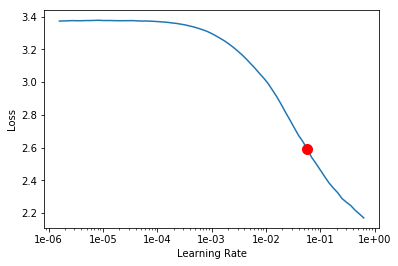

In [44]:
learn_c.lr_find()
learn_c.recorder.plot(skip_end=10, skip_start=15, suggestion=True)

In [57]:
learn_c.fit_one_cycle(1, 6e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.412187,0.532057,0.870000,00:01


In [55]:
learn_c.show_results(rows=300)

text,target,prediction
xxbos xxunk 2 45 12 1032 2083 xxunk xxunk xxunk 65 xxunk xxunk 65 xxunk xxunk 65 xxunk xxunk xxunk xxunk xxunk xxunk xxunk 65 xxunk xxunk xxunk xxunk 2083 xxunk xxunk 65 xxunk xxunk 65 xxunk xxunk,Informatica,Informatica
xxbos xxunk 2 45 68 xxunk xxunk 0 3308 0 12 1859 0 xxunk 0 65 xxunk xxunk xxunk 0 xxunk xxunk xxunk xxunk 0 xxunk xxunk xxunk 0 xxunk xxunk xxunk 0 0 6520 xxunk,Informatica,Cameras e Acessorios
xxbos xxunk 2 45 0 0 12 897 2851 68 xxunk 68 5 xxrep 4 6 68 xxunk 68 xxunk 68 xxunk xxunk xxunk xxunk xxunk xxunk 248 xxunk 248 xxunk xxunk xxunk xxunk,Informatica,Informatica
xxbos xxunk 2 593 12 1398 xxunk xxunk 90 xxunk 90 18 xxunk 90 xxunk 18 xxunk 90 0 xxunk 90 xxunk 0 xxunk 90 0 0 90 0 90 0 196 xxunk,Informatica,Informatica
xxbos xxunk 2 xxunk 269 19 816 261 xxunk 922 16 31 139 10 440 27 41 515 357 11 41 515 308 33 39 xxunk 177 26 18 209 63 177 xxunk,Informatica,Acessorios para Veiculos
xxbos xxunk 2 1180 1892 87 xxunk 11 31 xxunk 11 31 xxunk 10 20 204 10 20 204 10 27 2042 10 20 0 xxunk 10 20 10 27 11 31 xxunk,Acessorios para Veiculos,Ferramentas e Construcao
xxbos xxunk 2 593 12 135 2531 130 156 68 225 68 156 196 130 0 68 0 68 0 68 0 68 0 68 xxunk 0 68 0 68 156 xxunk,Informatica,Informatica
xxbos xxunk 2 45 130 27 183 xxunk 0 12 0 xxunk 135 130 68 1418 xxunk xxunk 185 xxunk 2408 xxunk 0 1864 0 1864 0 xxunk xxunk 0 288 xxunk,Informatica,Informatica
xxbos xxunk 2 45 75 xxunk 12 752 xxunk 196 xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk 8102 xxunk 0 xxunk xxunk 0 xxunk xxunk xxunk xxunk 0 xxunk,Informatica,Informatica
xxbos xxunk 2 330 515 191 41 18 1655 1530 xxunk 25 11 13 74 41 xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk 736 xxunk 10 xxunk 447 xxunk xxunk xxunk,Informatica,Informatica


In [78]:
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,2.730886,2.510026,0.350549,0.447430,16:11
1,2.535899,2.191126,0.465149,0.533706,16:46


/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jdg/miniconda3/envs/fastai/lib/pyt

/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jdg/miniconda3/envs/fastai/lib/pyt

/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jdg/miniconda3/envs/fastai/lib/pyt

/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jdg/miniconda3/envs/fastai/lib/pyt

In [18]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), wd=wd, moms=(0.8,0.7))

In [28]:
len("▁xxbos ▁cooler ▁para ▁hp ▁g 1 ▁1 d 1 d x ▁g 1 ▁1 d 1 d x ▁g 1 ▁1 d 1 d x ▁g 1 ▁1 d 1 d x ▁g 1 ▁1 d 1 d x ▁g 1 ▁1 d 1 ca ▁g 1 ▁1 d 1 ca ▁g 1 ▁1 d 1 d x ▁g 1 ▁1 d 1 ca ▁g 1 ▁1 d 1 ca ▁g 1 ▁1 d".split(" "))

74

In [ ]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), wd=wd, moms=(0.8,0.7))

In [ ]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7)

In [19]:
learn.fit_one_cycle(
    7, slice(3e-3/(2.6**4), 3e-3), moms=(0.8, 0.7), 
    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='class_fit_full_v3')]
)

epoch,train_loss,valid_loss,accuracy,time
0,0.701079,0.527963,0.852624,11:54
1,0.620078,0.528553,0.856442,11:36
2,0.597609,0.496313,0.867648,11:18
3,0.509029,0.472399,0.872179,11:45
4,0.476470,0.425087,0.885092,11:54
5,0.437726,0.389672,0.893379,11:52
6,0.389102,0.377394,0.897632,11:51


Better model found at epoch 0 with accuracy value: 0.8526244163513184.
Better model found at epoch 1 with accuracy value: 0.8564422726631165.
Better model found at epoch 2 with accuracy value: 0.8676475286483765.
Better model found at epoch 3 with accuracy value: 0.8721792697906494.
Better model found at epoch 4 with accuracy value: 0.8850917220115662.
Better model found at epoch 5 with accuracy value: 0.893379271030426.
Better model found at epoch 6 with accuracy value: 0.8976317048072815.


In [ ]:
learn.fit_one_cycle(
    7, slice(3e-4/(2.6**4), 3e-4), moms=(0.8, 0.7), 
)

epoch,train_loss,valid_loss,accuracy,time
0,0.392166,0.380484,0.895831,11:26
1,0.411268,0.385230,0.895180,11:26
2,0.400652,0.389359,0.893410,11:21
3,0.379885,0.383173,0.896980,11:21
4,0.345999,0.375771,0.898439,11:43
5,0.358352,0.372659,0.899463,11:23


In [ ]:
learn.fit_one_cycle(
    7, slice(3e-5/(2.6**4), 3e-5), moms=(0.8, 0.7), 
)